In [ ]:
import os
import sys
from google.colab import drive 
# Enlazar a la carpeta 'data'
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/Colab Notebooks/ICBF/data')
sys.path.insert(0, '../scripts/0_utils')
!pwd

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks/ICBF/data


# **Modelado a partir de los datos nutricionales**

####**Descripción:**

Explora diversas opciones de modelado a partir de las tablas de datos nutricionales y genera un modelo para predecir la reincidencia en desnutrición de un beneficiario a partir de sus datos nutricionales previos.
 
####**Requerimientos:**

- Conjuntos serializados `auxiliary_data/IdBeneficiario_train.pickle` y `auxiliary_data/IdBeneficiario_recuperacion.pickle` de los identificadores `IdBeneficiario` de los beneficiarios de los conjuntos de entrenamiento y de aquellos que sufrieron desnutrición y se recuperaron de ella, respectivamente.
- Tablas de datos nutricionales históricos `historical_data/historico_profundidad_i.parquet`, con `i` = 1, 2, 3, indicando el número de tomas anteriores tenidas en cuenta.
 
####**Salidas:**

- Modelos `models/model_min_i.pickle`, con `i` = 1, 2, 3, que predice si un beneficiario que ha sufrido de desnutrición pero no está desnutrido en la actualidad recaerá después de 1, 2 o 3 meses, en función de sus z-scores peso/talla, peso/edad e IMC actuales e inmediatamento anteriores.
- Listas serializada `models/model_min_i_cols.pickle`, con `i` = 1, 2, 3, con las variables nutricionales utilizadas por cada modelo como predictores.

In [ ]:
# Librerias relevantes 
import time
import pandas as pd
import numpy as np
import json
import re
import joblib
import random
# Modelado
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import ( 
  accuracy_score,
  precision_score,
  recall_score,
  f1_score,
  matthews_corrcoef as mcc,
  precision_recall_curve,
  make_scorer)
# Gráficas
import matplotlib.pyplot as plt
import seaborn as sns

# Opciones de visualización
pd.options.display.max_columns = 100
pd.options.display.max_rows = 100
%matplotlib inline
plt.style.use('ggplot')

### **Lectura de archivos**

Como el objetivo del modelado es intentar predecir la reincidencia en desnutrición, la población base serán los beneficiarios que sufrieron desnutrición y se recuperararon de ella.

In [ ]:
t0 = time.time()
# Beneficiarios en los conjuntos de entrenamiento y prueba
IdB_train = joblib.load('auxiliary_data/IdBeneficiario_train.pickle')
IdB_test = joblib.load('auxiliary_data/IdBeneficiario_test.pickle')
# Tablas de datos nutricionales con información de las tomas anteriores
his = list()
his_test = list()
prevalencias = list()
for i in range(4):
  # Abre las tablas de datos nutricionales con información de las tomas anteriores
  tom = pd.read_parquet(f'historical_data/historico_profundidad_{i + 1}.parquet')
  # Beneficiarios que han sufrido desnutrición, pero actualmente no la sufren
  tom = tom[(tom['ZScorePesoTalla-1'] > -2) & (tom['desnutricion_previa'] > 0)]
  # Columnas relevantes
  cols_edad = [col for col in tom.columns if col[:4] == 'Edad']
  cols_medidas = [col for col in tom.columns if col[:4] == 'Peso' or col[:5] == 'Talla']
  cols_zscore = [col for col in tom.columns if col[:6] == 'ZScore']
  cols_tom = ['IdBeneficiario', 'desnutricion_previa'] + \
    sorted(cols_edad) + sorted(cols_medidas) + sorted(cols_zscore) + ['tiempo', 'desnutricion']
  tom = tom[cols_tom]
  # Divide las tomas en conjuntos de entrenamiento y prueba
  train = tom[tom['IdBeneficiario'].isin(IdB_train)]
  test = tom[tom['IdBeneficiario'].isin(IdB_test)]
  # Prevalencia de la reincidencia
  prevalencias.append(tom['desnutricion'].mean())
  his.append(train)
  his_test.append(test)

### **Preliminares**

In [ ]:
# Prevalencia promedio de la desnutrición
prevalencia = np.mean(prevalencias)
print(f"Prevalencia de la reincidencia en desnutrición: {prevalencia:.2%}.")
# Métricas a utilizar
testing_metrics = ['accuracy', 'precision', 'recall', 'f1', 'mcc']
# Datos nulos
nulos = tom.isna().mean()
nulos[nulos > 0]

Prevalencia de la reincidencia en desnutrición: 2.81%.


Peso-2               0.000006
Peso-3               0.000006
Peso-4               0.000004
Talla-1              0.000002
Talla-2              0.000008
Talla-3              0.000006
Talla-4              0.000010
ZScoreIMC-1          0.000762
ZScoreIMC-2          0.003283
ZScoreIMC-3          0.005303
ZScoreIMC-4          0.007869
ZScorePesoEdad-1     0.000190
ZScorePesoEdad-2     0.000644
ZScorePesoEdad-3     0.000931
ZScorePesoEdad-4     0.001584
ZScorePesoTalla-2    0.001430
ZScorePesoTalla-3    0.002582
ZScorePesoTalla-4    0.004279
ZScoreTallaEdad-1    0.003307
ZScoreTallaEdad-2    0.005465
ZScoreTallaEdad-3    0.007538
ZScoreTallaEdad-4    0.009889
dtype: float64

### **Parámetros para la optimización de los modelos de *random forest***

Siguiendo nuestra experiencia previa registraremos las métricas utilizadas (*accuracy*, *precision*, *recall* y *f1-score*), equilibrando la *precision* y el *recall*, al intentar optimizar el *f1-score*. Por defecto, los modelos se construirán con los siguientes hiperparámetros:

- **Número de árboles (`n_estimators`)**: 150 o 200.
- **Profundidad máxima (`max_depth`)**: 5 o 10.
- **Número mínimo de muestras por hoja (`min_samples_leaf`)**: 1 ó 2.

In [ ]:
# Parámetros a utilizar para la optimización de los random forest
parameters = {
  'max_depth': [5, 10],
  'min_samples_leaf': [1, 2],
  'n_estimators': [150, 200]
  }
scorers = {
  'precision_score': make_scorer(precision_score),
  'f1_score': make_scorer(f1_score),
  'mcc': make_scorer(mcc)}
def train_test_rf(df, seed=1, test_size=0.3, parameters=parameters, verbose=1):
  ''' Particiona los beneficiarios de un dataframe en conjuntos de entrenamiento y validación, 
  submuestreando las muestras de la clase mayoritaria (no desnutrición) en el conjunto de entrenamiento
  para igualar el número de muestras de la clase minoritaria. 
  Genera un random forest de clasificación a partir del conjunto de entrenamiento balanceado, 
  habiendo optimizado los hiperparámetros.
  Reporta las métricas de la clasificación del modelo en ambos conjuntos de datos y la importancia de cada variable.
  '''
  df = df.dropna()
  # Particiona los beneficiarios en conjuntos de entrenamiento y validación
  idB = list(df['IdBeneficiario'].unique())
  train_ids, test_ids = train_test_split(idB, test_size = test_size, random_state=seed)
  # Balancea el conjunto de beneficiarios en el conjunto de entrenamiento extrayendo
  # todas las muestras positivas y el mismo número de muestras negativas 
  df_train_unbalanced = df[df['IdBeneficiario'].isin(train_ids)]
  df_train_positive = df_train_unbalanced[df_train_unbalanced['desnutricion']]
  df_train_negative = df_train_unbalanced[~df_train_unbalanced['desnutricion']]
  df_train_negative_balanced = df_train_negative.sample(n = len(df_train_positive), random_state=seed)
  df_train = pd.concat([df_train_positive, df_train_negative_balanced]).sample(frac=1, random_state=seed)
  # Extrae las muestras de los beneficiarios de prueba (sin balancear)
  df_test = df[df['IdBeneficiario'].isin(test_ids)]
  # Define las variables predictoras y la variable objetivo
  X_train = df_train.drop(columns=['desnutricion', 'IdBeneficiario'])
  X_test = df_test.drop(columns=['desnutricion', 'IdBeneficiario'])
  y_train = df_train['desnutricion']
  y_test = df_test['desnutricion']
  # Realiza una búsqueda exahustiva para optimizar los hiperparámetros del random forest
  classifier = GridSearchCV(RandomForestClassifier(criterion='gini', random_state=seed), 
                            parameters, n_jobs=10, cv=5, verbose=verbose, scoring=scorers, 
                            refit='f1_score')
  # Extrae el mejor modelo y las predicciones en los conjuntos de entrenamiento y validación
  classifier.fit(X=X_train, y=y_train)
  model = classifier.best_estimator_
  y_pred_train = model.predict(X_train)
  y_pred_test = model.predict(X_test)
  # Calcula y guarda las métricas y los hiperparámetros en un dataframe
  metrics = pd.DataFrame({
      'random_state': seed,
      'accuracy': accuracy_score(y_test, y_pred_test),
      'precision': precision_score(y_test, y_pred_test),
      'recall': recall_score(y_test, y_pred_test),
      'f1': f1_score(y_test, y_pred_test),
      'mcc': mcc(y_test, y_pred_test),
      'max_depth': classifier.best_params_['max_depth'],
      'min_samples_leaf': classifier.best_params_['min_samples_leaf'],
      'n_trees': classifier.best_params_['n_estimators']
      }, index=[seed]).round(3)
  # Calcula y guarda la importancia de cada variable predictora
  importance = pd.Series({X_train.columns[i]: model.feature_importances_[i] 
                          for i in range(len(model.feature_importances_))})
  # Retorna el modelo, las métricas y la importancia de las variables en orden decreciente
  return (model, metrics, importance.sort_values(ascending=False))

### **Modelo con información nutricional completa**
#### **Variables**
De las tomas nutricionales más recientes:
- Edad (`EdadMeses`)
- Peso (`Peso`)
- Talla (`Talla`)
- z-score IMC (`ZScoreIMC`)
- z-score peso/edad (`ZScorePesoEdad`)
- z-score peso/talla (`ZScorePesoTalla`)
- z-score talla/edad (`ZScoreTallaEdad`)
- Desnutrición previa (`desnutricion_previa`)

####**Modelos a probar**:
- **Horizonte de predicción (`tiempo`):**  De 1, 2, 3, 4 o 6 meses.
- **Número de tomas anteriores (`tomas`):** De 1 a 3 tomas.
- 3 **réplicas** por cada combinación, con el índice de la fila como semilla aleatoria.

In [ ]:
# Dataframe con las características de los modelos a probar:
models_features = pd.DataFrame([[tiempo, tomas]
  for tiempo in [1, 2, 3, 4, 6]
  for tomas in range(1, 5)
  for replica in range(3)],
  columns=['tiempo', 'tomas'])
models_features.drop_duplicates()

tiempo  tomas
0        1      1
3        1      2
6        1      3
9        1      4
12       2      1
15       2      2
18       2      3
21       2      4
24       3      1
27       3      2
30       3      3
33       3      4
36       4      1
39       4      2
42       4      3
45       4      4
48       6      1
51       6      2
54       6      3
57       6      4

In [ ]:
metrics_list = list()
importance_list = list()
parameters = {'max_depth': [10],
              'min_samples_leaf': [1],
              'n_estimators': [300]
              }
for i, features in models_features.iterrows():
  tiempo, n_tomas = features['tiempo'], features['tomas']
  df = his[n_tomas - 1]
  df = df[df['tiempo'] == tiempo].dropna()
  training = train_test_rf(df, seed=i, test_size=0.3, parameters=parameters, verbose=0)
  features = pd.DataFrame({'registros': df.shape[0],
                           'columnas': df.shape[1] - 2,
                           'tiempo': tiempo,
                           'tomas': n_tomas,
                           'tipo': 'Todas'
                           }, index = [i])
  print(f"Modelo {i}: {df.shape[1] - 2} variables, incluyendo {n_tomas} tomas anteriores para {tiempo} meses." + 
        f"Tiempo: {time.time() - t0:.2f} s.")
  model_details = pd.concat([training[1], features], axis=1)
  metrics_list.append(model_details)
  importance_list.append(training[2])
metrics_all = pd.concat(metrics_list)
importance_all = pd.concat(importance_list, axis=1).transpose()
metrics_all.groupby(['tiempo', 'tomas'])[testing_metrics].mean()

Modelo 0: 10 variables, incluyendo 1 tomas anteriores para 1 meses.Tiempo: 85.56 s.
Modelo 1: 10 variables, incluyendo 1 tomas anteriores para 1 meses.Tiempo: 96.18 s.
Modelo 2: 10 variables, incluyendo 1 tomas anteriores para 1 meses.Tiempo: 104.60 s.
Modelo 3: 17 variables, incluyendo 2 tomas anteriores para 1 meses.Tiempo: 114.97 s.
Modelo 4: 17 variables, incluyendo 2 tomas anteriores para 1 meses.Tiempo: 125.36 s.
Modelo 5: 17 variables, incluyendo 2 tomas anteriores para 1 meses.Tiempo: 135.68 s.
Modelo 6: 24 variables, incluyendo 3 tomas anteriores para 1 meses.Tiempo: 145.51 s.
Modelo 7: 24 variables, incluyendo 3 tomas anteriores para 1 meses.Tiempo: 155.39 s.
Modelo 8: 24 variables, incluyendo 3 tomas anteriores para 1 meses.Tiempo: 165.32 s.
Modelo 9: 31 variables, incluyendo 4 tomas anteriores para 1 meses.Tiempo: 175.78 s.
Modelo 10: 31 variables, incluyendo 4 tomas anteriores para 1 meses.Tiempo: 185.79 s.
Modelo 11: 31 variables, incluyendo 4 tomas anteriores para 1 mese

accuracy  precision    recall        f1       mcc
tiempo tomas                                                   
1      1      0.756667   0.095000  0.731667  0.168333  0.201000
       2      0.757333   0.097667  0.752333  0.172333  0.209667
       3      0.762000   0.095667  0.766000  0.170333  0.213000
       4      0.764667   0.088000  0.795000  0.157667  0.211333
2      1      0.745667   0.070333  0.648000  0.127000  0.149667
       2      0.741333   0.072667  0.705333  0.131667  0.165667
       3      0.740333   0.068667  0.702000  0.124667  0.159667
       4      0.736667   0.064000  0.719667  0.117667  0.158000
3      1      0.761333   0.071667  0.679333  0.130000  0.163667
       2      0.756333   0.073000  0.706000  0.132333  0.170333
       3      0.754000   0.069333  0.724000  0.126667  0.170000
       4      0.759000   0.068000  0.736333  0.125000  0.172333
4      1      0.727667   0.074000  0.612000  0.131667  0.138333
       2      0.702333   0.071667  0.658333  0.129000  0.141333
       3      0.733333   0.077333  0.681333  0.138667  0.162333
       4      0.718000   0.076667  0.692667  0.138000  0.160000
6      1      0.596333   0.070333  0.689000  0.128000  0.115667
       2      0.618667   0.065667  0.699000  0.119333  0.121667
       3      0.641000   0.064000  0.631000  0.116000  0.106667
       4      0.668000   0.061000  0.666333  0.111333  0.123000

In [ ]:
metrics_all = pd.concat(metrics_list)
importance_all = pd.concat(importance_list, axis=1).transpose()
metrics_all.groupby(['tiempo', 'tomas']).mean()

In [ ]:
metrics_all.groupby('tiempo')[testing_metrics].mean()

In [ ]:
# Gráfica de precision vs recall
fig = sns.scatterplot(data=metrics_all,  x='recall', y='precision',
                      hue='tiempo', size='tomas', palette='bright')
fig.set_xlim([0.5, 0.85])
fig.set_ylim([0.0, 0.15])
fig.set_xlabel('Recall')
fig.set_ylabel('Precision')
fig.axhline(prevalencia, 0, 1, color='black', linestyle="dashed")
plt.show()
# Columnas más importantes
importance_all.mean().sort_values(ascending=False)

Como es de esperarse, las ventanas de predicción a corto plazo (1 o 2 meses) presentan unas mejores métricas de *precision* y *f1-score*, que las que tienen predicciones a más largo plazo, resultando bastante erráticas para 6 meses. En general, tomar más de una toma previa no optimiza significativamente los valores de *recall* y en cambio sí puede reducir ligeramente los de *precision*.

### **Modelo mínimo nutricional**
#### **Variables**
De las tomas nutricionales más recientes:
- Edad (`EdadMeses`)
- z-score peso/talla (`ZScorePesoTalla`)
- z-score IMC (`ZScoreIMC`)
- z-score peso/edad (`ZScorePesoEdad`)

####**Modelos a probar**:
- **Horizonte de predicción (`tiempo`):**  De 1, 2, 3, 4 y 6 meses.
- **Número de tomas anteriores (`tomas`):** 1 toma anterior.
- 10 **réplicas** por cada combinación, con el índice de la fila como semilla aleatoria.

In [ ]:
# Dataframe con las características de los modelos a probar:
models_features = pd.DataFrame([[tiempo, tomas]
  for tiempo in [1, 2, 3, 4, 6]
  for tomas in [1, 2]
  for replica in range(5)],
  columns=['tiempo', 'tomas'])
models_features.drop_duplicates()

In [ ]:
metrics_list = list()
importance_list = list()
parameters = {'max_depth': [10],
              'min_samples_leaf': [1, 2],
              'n_estimators': [300]
              }
for i, features in models_features.iterrows():
  tiempo, n_tomas = features['tiempo'], features['tomas']
  df = his[n_tomas - 1]
  cols_zscore_peso = [col for col in df.columns if col[:10] == 'ZScorePeso']
  cols_zscore_IMC = [col for col in df.columns if col[:9] == 'ZScoreIMC']
  cols_min = ['EdadMeses'] + cols_zscore_peso + cols_zscore_IMC
  df = df[df['tiempo'] == tiempo][['IdBeneficiario'] + cols_min + ['desnutricion']].dropna()
  training = train_test_rf(df, seed=i, test_size=0.3, parameters=parameters, verbose=0)
  features = pd.DataFrame({'registros': df.shape[0],
                           'columnas': df.shape[1] - 2,
                           'tiempo': tiempo,
                           'tomas': n_tomas,
                           'tipo': 'Mínimo'
                           }, index = [i])
  print(f"Modelo {i}: {df.shape[1] - 2} variables, "+
        f"incluyendo {n_tomas} toma(s) anterior(es) para {tiempo} meses." + 
        f"Tiempo: {time.time() - t0:.2f} s.")
  model_details = pd.concat([training[1], features], axis=1)
  metrics_list.append(model_details)
  importance_list.append(training[2])
metrics_min = pd.concat(metrics_list)
importance_min = pd.concat(importance_list, axis=1).transpose()
metrics_min.groupby(['tiempo', 'tomas'])[testing_metrics].mean()

Modelo 0: 4 variables, incluyendo 1 toma(s) anterior(es) para 1 meses.Tiempo: 728.25 s.
Modelo 1: 4 variables, incluyendo 1 toma(s) anterior(es) para 1 meses.Tiempo: 740.74 s.
Modelo 2: 4 variables, incluyendo 1 toma(s) anterior(es) para 1 meses.Tiempo: 753.55 s.
Modelo 3: 4 variables, incluyendo 1 toma(s) anterior(es) para 1 meses.Tiempo: 766.15 s.
Modelo 4: 4 variables, incluyendo 1 toma(s) anterior(es) para 1 meses.Tiempo: 778.96 s.
Modelo 5: 7 variables, incluyendo 2 toma(s) anterior(es) para 1 meses.Tiempo: 792.41 s.
Modelo 6: 7 variables, incluyendo 2 toma(s) anterior(es) para 1 meses.Tiempo: 805.71 s.
Modelo 7: 7 variables, incluyendo 2 toma(s) anterior(es) para 1 meses.Tiempo: 819.01 s.
Modelo 8: 7 variables, incluyendo 2 toma(s) anterior(es) para 1 meses.Tiempo: 832.22 s.
Modelo 9: 7 variables, incluyendo 2 toma(s) anterior(es) para 1 meses.Tiempo: 845.71 s.
Modelo 10: 4 variables, incluyendo 1 toma(s) anterior(es) para 2 meses.Tiempo: 858.24 s.
Modelo 11: 4 variables, incluye

accuracy  precision  recall      f1     mcc
tiempo tomas                                             
1      1        0.7498     0.0924  0.7366  0.1640  0.1980
       2        0.7454     0.0948  0.7808  0.1690  0.2108
2      1        0.7482     0.0698  0.6538  0.1262  0.1514
       2        0.7346     0.0722  0.7030  0.1310  0.1630
3      1        0.7684     0.0724  0.6662  0.1304  0.1632
       2        0.7634     0.0744  0.7036  0.1344  0.1730
4      1        0.7176     0.0736  0.6396  0.1316  0.1424
       2        0.7138     0.0714  0.6548  0.1290  0.1436
6      1        0.5914     0.0622  0.6114  0.1128  0.0826
       2        0.6358     0.0648  0.5798  0.1170  0.0902

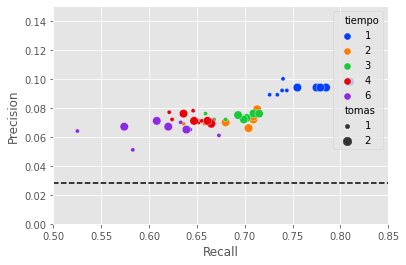

ZScorePesoTalla-1    0.273964
ZScoreIMC-1          0.224824
ZScorePesoEdad-1     0.183951
ZScorePesoTalla-2    0.143920
ZScoreIMC-2          0.133487
ZScorePesoEdad-2     0.132528
EdadMeses            0.112293
dtype: float64

In [ ]:
# Gráfica de precision vs recall
fig = sns.scatterplot(data=metrics_min,  x='recall', y='precision',
                      hue='tiempo', size='tomas', palette='bright')
fig.set_xlim([0.5, 0.85])
fig.set_ylim([0.0, 0.15])
fig.set_xlabel('Recall')
fig.set_ylabel('Precision')
fig.axhline(prevalencia, 0, 1, color='black', linestyle="dashed")
plt.show()
# Columnas más importantes
importance_min.mean().sort_values(ascending=False)

### **Modelos finales, curva *precision-recall* y distribución de *p-scores***

Los modelos finales se construyen a partir de las dos últimas tomas nutricionales de cada beneficiario, utilizando todos los datos de entrenamiento y se ampliará el conjunto de parámetros para realizar la búsqueda.

Los modelos intentarán predecir la recurrencia en desnutrición uno y tres meses después de la última valoración nutricional. Ambos modelos se evalúan en los beneficiarios del conjunto de prueba.

Modelo 'model_min_1.pickle' guardado: 1931.45 s.


random_state  accuracy  precision  recall    f1    mcc  max_depth  \
1            12     0.761      0.096   0.753  0.17  0.209          6   

   min_samples_leaf  n_trees  
1                 2      250

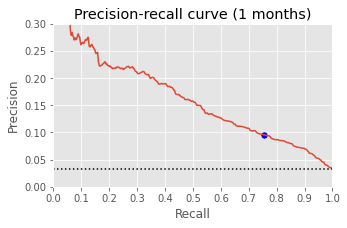

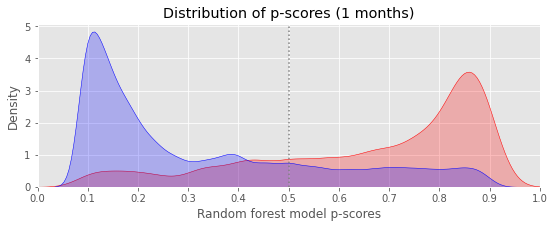

Modelo 'model_min_2.pickle' guardado: 2451.16 s.


random_state  accuracy  precision  recall     f1    mcc  max_depth  \
2            12      0.75      0.079     0.7  0.143  0.175         10   

   min_samples_leaf  n_trees  
2                 4      150

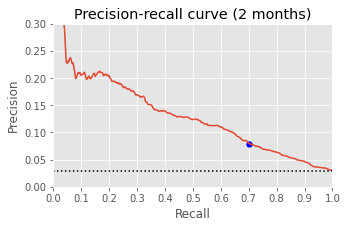

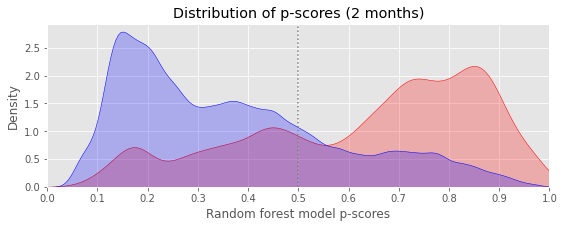

Modelo 'model_min_3.pickle' guardado: 3620.59 s.


random_state  accuracy  precision  recall    f1    mcc  max_depth  \
3            12      0.76      0.071   0.698  0.13  0.168          8   

   min_samples_leaf  n_trees  
3                 2      250

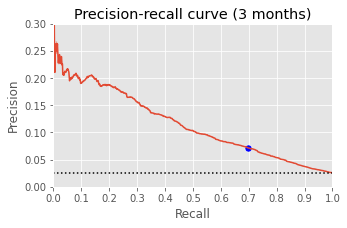

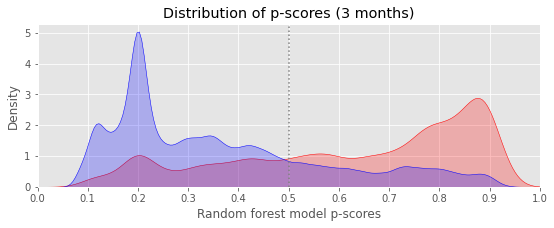

In [ ]:
# Modelo mínimo
model_min = dict()
seed = 12
n_tomas = 2
parameters = {'max_depth': [2 * (i + 1) for i in range(10)],
              'min_samples_leaf': [1, 2, 3, 4],
              'n_estimators': [150, 200, 250]
              }
for tiempo in [1, 2, 3]:
  # Toma todo el conjunto de datos de entrenamiento
  df = his[n_tomas - 1]
  cols_zscore_peso = [col for col in df.columns if col[:10] == 'ZScorePeso']
  cols_zscore_IMC = [col for col in df.columns if col[:9] == 'ZScoreIMC']
  cols_min = ['EdadMeses'] + cols_zscore_peso + cols_zscore_IMC
  df_train_unbalanced = df.loc[df['tiempo'] == tiempo, 
                               ['IdBeneficiario'] + cols_min + ['desnutricion']].\
                               dropna()
  # Balancea el conjunto de beneficiarios en el conjunto de entrenamiento extrayendo
  # todas las muestras positivas y el mismo número de muestras negativas 
  #df_train_unbalanced = df[df['IdBeneficiario'].isin(train_ids)]
  df_train_positive = df_train_unbalanced[df_train_unbalanced['desnutricion']]
  df_train_negative = df_train_unbalanced[~df_train_unbalanced['desnutricion']]
  df_train_negative_balanced = df_train_negative.sample(n = len(df_train_positive), random_state=seed)
  df_train = pd.concat([df_train_positive, df_train_negative_balanced]).sample(frac=1, random_state=seed)
  # Extrae las muestras de los beneficiarios de prueba (sin balancear)
  df_test = his_test[n_tomas - 1]
  df_test = df_test.loc[df_test['tiempo'] == tiempo, ['IdBeneficiario'] + cols_min + ['desnutricion']].\
    dropna()
  # Define las variables predictoras y la variable objetivo
  X_train = df_train.drop(columns=['desnutricion', 'IdBeneficiario'])
  X_test = df_test.drop(columns=['desnutricion', 'IdBeneficiario'])
  y_train = df_train['desnutricion']
  y_test = df_test['desnutricion']
  # Realiza una búsqueda exahustiva para optimizar los hiperparámetros del random forest
  classifier = GridSearchCV(RandomForestClassifier(criterion='gini', random_state=seed), 
                            parameters, n_jobs=10, cv=5, verbose=0, scoring=scorers, 
                            refit='f1_score')
  # Extrae el mejor modelo y las predicciones en los conjuntos de entrenamiento y validación
  classifier.fit(X=X_train, y=y_train)
  model_min = classifier.best_estimator_
  y_pred_train = model_min.predict(X_train)
  y_pred_test = model_min.predict(X_test)
  # Probabilidades (p-scores) asociadas a cada beneficiario en el conjunto de prueba
  p_scores = [q for p, q in model_min.predict_proba(X_test)]
  # Calcula y guarda las métricas y los hiperparámetros en un dataframe
  metrics = pd.DataFrame({
      'random_state': seed,
      'accuracy': accuracy_score(y_test, y_pred_test),
      'precision': precision_score(y_test, y_pred_test),
      'recall': recall_score(y_test, y_pred_test),
      'f1': f1_score(y_test, y_pred_test),
      'mcc': mcc(y_test, y_pred_test),
      'max_depth': classifier.best_params_['max_depth'],
      'min_samples_leaf': classifier.best_params_['min_samples_leaf'],
      'n_trees': classifier.best_params_['n_estimators']
      }, index=[tiempo]).round(3)
  # Guarda la lista de variables y el modelo para su implementación
  joblib.dump(model_min, f'models/model_min_{tiempo}.pickle')
  joblib.dump(list(X_train.columns), f'models/model_min_{tiempo}_cols.pickle')
  print(f"Modelo 'model_min_{tiempo}.pickle' guardado: {time.time() - t0:.2f} s.")
  display(metrics)
  # Grafica la curva precision-recall
  plt.rcParams["figure.figsize"] = (5, 3)
  precision, recall, thresholds = precision_recall_curve(y_test, p_scores)
  fig = sns.lineplot(x=recall, y=precision, palette='Reds')
  fig = sns.scatterplot(data=metrics, x='recall', y='precision', s=50, color='blue')
  fig.set_title(f"Precision-recall curve ({tiempo} months)")
  fig.set_xticks([0.1 * i for i in range(11)])
  fig.set_yticks([0.05 * i for i in range(21)])
  fig.set_xlim([0, 1])
  fig.set_ylim([0, 0.3])
  fig.set_xlabel('Recall')
  fig.set_ylabel('Precision')
  fig.axhline(y_test.mean(), 0, 1, color='black', linestyle="dotted", linewidth=1.5)
  plt.show()
  # Grafica la distribución de p-scores por cada clase
  distribution = pd.DataFrame({'p_scores': p_scores,
                               'y_test': y_test})
  plt.rcParams["figure.figsize"] = (9, 3)
  # Densidad de cada distribución
  fig = sns.kdeplot(distribution[distribution['y_test']]['p_scores'],
                    shade=True, color="red", clip=[0, 1], bw_adjust=0.5)
  fig = sns.kdeplot(distribution[~distribution['y_test']]['p_scores'],
                    shade=True, color="blue", clip=[0, 1], bw_adjust=0.5)
  fig.set_xticks([0.1 * i for i in range(11)])
  fig.axvline(0.5, 0, 10, color='grey', linestyle="dotted", linewidth=1.5)
  fig.set_xlim([0, 1])
  fig.set_title(f"Distribution of p-scores ({tiempo} months)")
  fig.set_xlabel('Random forest model p-scores')
  fig.set_ylabel('Density')
  plt.show()